In [24]:
import pandas as pd 
import numpy as np
import ast 
import os 
import joblib

from Levenshtein import distance as levenshtein_distance
from rdkit import Chem
from mapchiral import mapchiral
import tmap as tm 
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from faerun import Faerun
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 10})

from eval_functions import *

## TMAP: COCONUT DB

#### Import data frame

Import dataset with training, validation and test data.

In [2]:
coconut_complete = pd.read_csv('data/coconut/coconut_clean_splits.csv')

Import dataset of structures removed because of incomplete stereocenter assignment.

In [27]:
coconut_incomplete = pd.read_csv('data/coconut/coconut_incomplete_clean.csv')
coconut_incomplete['split'] = 'incomplete'

Combine data frames for the full dataset with associated DOIs.

In [28]:
coconut_combined = pd.concat([coconut_complete, coconut_incomplete])

Check intersection

In [29]:
overlap = coconut_complete[coconut_complete['absolute_smiles'].isin(coconut_incomplete['absolute_smiles'])]
print(len(overlap))

5497


Add chemical class

In [30]:
peptide = '[NX3,NX4+][CH1,CH2][CX3](=[OX1])[NX3,NX4+][CH1,CH2][CX3](=[OX1])[O,N]'
sugar = '[CR][OR][CHR]([OR0,NR0])[CR]'

def match_pattern(row, pattern, name):
    mol = Chem.MolFromSmiles(row['absolute_smiles'])
    if mol.HasSubstructMatch(Chem.MolFromSmarts(pattern)):
        return name 
    else:
        return row['chemical_class_new']

def clean_chemical_class(chemical_class): 
    if chemical_class == '"Lipids and lipid-like molecules"':
        return 'Lipids & Terpenes'
    elif chemical_class == '"Phenylpropanoids and polyketides"':
        return 'Polyketides'
    elif chemical_class == '"Alkaloids and derivatives"':
        return 'Alkaloids'
    elif chemical_class == '"Benzenoids"':
        return 'Benzenoids'
    elif chemical_class == 'Peptides':
        return 'Peptides'
    elif chemical_class == '"Lignans, neolignans and related compounds"':
        return 'Lignans'
    elif chemical_class == '"Nucleosides, nucleotides, and analogues"':
        return 'Nucleosides'
    elif chemical_class == 'Glycosides':
        return 'Glycosides'
    else:
        return 'Other'
    
coconut_complete['chemical_class_new'] = coconut_complete['chemical_super_class'].values.tolist()
coconut_complete['chemical_class_new'] = coconut_complete.apply(lambda x: match_pattern(x, sugar, 'Glycosides'), axis=1)
coconut_complete['chemical_class_new'] = coconut_complete.apply(lambda x: match_pattern(x, peptide, 'Peptides'), axis=1)
coconut_complete['chemical_class_new'] = coconut_complete['chemical_class_new'].apply(clean_chemical_class)

coconut_combined['chemical_class_new'] = coconut_combined['chemical_super_class'].values.tolist()
coconut_combined['chemical_class_new'] = coconut_combined.apply(lambda x: match_pattern(x, sugar, 'Glycosides'), axis=1)
coconut_combined['chemical_class_new'] = coconut_combined.apply(lambda x: match_pattern(x, peptide, 'Peptides'), axis=1)
coconut_combined['chemical_class_new'] = coconut_combined['chemical_class_new'].apply(clean_chemical_class)

Clean number of stereocenters

In [31]:
coconut_complete['num_stereocenters_new'] = coconut_complete['num_stereocenters'].apply(lambda x: x if x <= 10 else 11)
coconut_complete['num_stereoisomers_new'] = coconut_complete['num_stereoisomers'].apply(lambda x: x if x <= 10 else 11)

coconut_combined['num_stereocenters_new'] = coconut_combined['num_stereocenters'].apply(lambda x: x if x <= 10 else 11)
coconut_combined['num_stereoisomers_new'] = coconut_combined['num_stereoisomers'].apply(lambda x: x if x <= 10 else 11)

#### 3D bar plot

Stereoisomers vs. stereocenters for the full dataset.

In [ ]:
grouped = coconut_complete.groupby(['num_stereocenters_new', 'num_stereoisomers_new']).size().reset_index(name='counts')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = grouped['num_stereoisomers_new']
y = grouped['num_stereocenters_new']
z = grouped['counts']

dx = dy = 0.5  
dz = z

ax.bar3d(x, y, np.zeros_like(z), dx, dy, dz, shade=True, color='#648FFF')

ax.set_xticks(list(grouped['num_stereoisomers_new'].unique()))
ax.set_xticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_stereoisomers_new'].unique()])

ax.set_yticks(list(grouped['num_stereocenters_new'].unique()))
ax.set_yticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_stereocenters_new'].unique()])

plt.savefig('plots/3d_barplot_stereocenters_stereoisomers.png', dpi=1200)

Stereocenters vs. unassigned stereocenters for the incomplete dataset.

In [ ]:
coconut_incomplete_flat = pd.read_csv('data/coconut/coconut_incomplete.csv')

coconut_incomplete_flat['num_stereocenters'] = coconut_incomplete_flat['num_stereocenters'].apply(lambda x: x if x <= 10 else 11)
coconut_incomplete_flat['num_unassigned'] = coconut_incomplete_flat['num_unassigned'].apply(lambda x: x if x <= 10 else 11)

grouped = coconut_incomplete_flat.groupby(['num_stereocenters', 'num_unassigned']).size().reset_index(name='counts')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = grouped['num_unassigned']
y = grouped['num_stereocenters']
z = grouped['counts']

dx = dy = 0.5  
dz = z

ax.bar3d(x, y, np.zeros_like(z), dx, dy, dz, shade=True, color='#DC267F')

ax.set_xticks(list(grouped['num_stereocenters'].unique()))
ax.set_xticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_stereocenters'].unique()])

ax.set_yticks(list(grouped['num_unassigned'].unique()))
ax.set_yticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_unassigned'].unique()])

plt.savefig('plots/3d_barplot_stereocenters_unassigned.png', dpi=1200)

Calculate MAP4C fingerprints for the full dataset.

In [27]:
coconut_combined['smiles'] = coconut_combined['smiles'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
coconut_combined['identifier'] = coconut_combined['identifier'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
coconut_combined_exploded = coconut_combined.explode('smiles').explode('identifier').drop_duplicates(subset=['smiles']).reset_index(drop=True)

In [28]:
if not os.path.exists('data/fingerprints/coconut_combined_map4c.joblib'):
    coconut_combined_exploded['map4c'] = coconut_combined_exploded['smiles'].apply(lambda x: mapchiral.encode(Chem.MolFromSmiles(x), max_radius=2, n_permutations=2048))
    joblib.dump(coconut_combined_exploded['map4c'], 'data/fingerprints/coconut_combined_map4c.joblib')
else:
    coconut_combined_exploded['map4c'] = joblib.load('data/fingerprints/coconut_combined_map4c.joblib')

Reorder to have splits mixed for homogeneous display on the TMAP plot.

In [29]:
coconut_combined_shuffled = coconut_combined_exploded.sample(frac=1, random_state=42).reset_index(drop=True)

#### TMAP

Generate layout

In [30]:
if not os.path.exists(f'plots/tmaps/layouts/coconut_combined_layout.pkl'):
    
    lf = tm.LSHForest(2048, 32)

    map4 = np.array(coconut_combined_shuffled['map4c'])
    fps = []

    for i in map4:
        vec = tm.VectorUint(i)
        fps.append(vec)

    lf.batch_add(fps)
    lf.index()

    cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
    cfg.node_size = 1/32.5 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
    cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
    cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
    cfg.k = 20 #number of nearest neighbours used to create the k-nearest neighbour graph
    cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)
    tm_layout = {'x': list(x), 'y': list(y), 's': list(s), 't': list(t)}
    joblib.dump(tm_layout, f'plots/tmaps/layouts/coconut_combined_layout.pkl')
else:
    tm_layout = joblib.load(f'plots/tmaps/layouts/coconut_combined_layout.pkl')

TMAP: number of stereocenters

In [ ]:
nstereo_colors = {0: '#D6D6D6', 1: '#648FFF', 2: '#6D79F8', 3: '#7663F2', 4: '#994BCA', 5: '#C63298', 6: '#E43363', 7: '#F34D2A', 8: '#FE6A00', 9: '#FF8D00', 10: '#FFB000', 11: '#FFDD00'}
colors = coconut_combined_shuffled['num_stereocenters_new'].map(nstereo_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=0.1, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_nstereo.png', dpi=1200, bbox_inches='tight')

TMAP: splits

In [ ]:
nstereo_colors = {'train': '#D6D6D6', 'validation': '#DC267F', 'test': '#648FFF', 'incomplete': '#FFB000'}
colors = coconut_combined_shuffled['split'].map(nstereo_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=1, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_splits.png', dpi=1200, bbox_inches='tight')

TMAP: chemical classes

In [ ]:
category_colors = {'Benzenoids': '#648FFF', 'Nucleosides': '#785EF0', 'Alkaloids': '#DC267F', 'Lignans': '#FE6100', 'Polyketides': '#2CA02C', 'Lipids & Terpenes': '#FFB000', 'Glycosides': '#8F2D56', 'Peptides': '#33A1C9', 'Other': '#B3B3B3'}
colors = coconut_combined_shuffled['chemical_class_new'].map(category_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=0.25, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_chemical_classes.png', dpi=1200, bbox_inches='tight')

## Training Set Analysis

#### Analyse different chirality removal strategies

Import dataset

In [41]:
def randomize_smiles(smiles, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed()

    mol = Chem.MolFromSmiles(smiles)
    atoms = list(range(mol.GetNumAtoms()))
    np.random.shuffle(atoms)
    new_mol = Chem.RenumberAtoms(mol, atoms)
    return Chem.MolToSmiles(new_mol, canonical=False, isomericSmiles=True)

In [42]:
dataset = pd.read_csv('data/dataset_not_augmented.csv')

dataset['target'] = dataset['target'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
dataset['absolute_canonical_smiles'] = dataset['target'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False, canonical=True))
dataset['absolute_smiles'] = dataset['target'].apply(lambda x: flatten(x))
dataset['absolute_randomized_smiles'] = dataset['absolute_canonical_smiles'].apply(lambda x: randomize_smiles(x, seed=42))

Determine Levenshtein distances

In [43]:
dataset['levenshtein_absolute_smiles'] = dataset.apply(lambda x: levenshtein_distance(x['absolute_smiles'], x['absolute_canonical_smiles']), axis=1)
dataset['levenshtein_randomized_smiles'] = dataset.apply(lambda x: levenshtein_distance(x['absolute_randomized_smiles'], x['absolute_canonical_smiles']), axis=1)

print('Absolute SMILES: {:.2f} ± {:.2f}'.format(dataset['levenshtein_absolute_smiles'].mean(), dataset['levenshtein_absolute_smiles'].std()))
print('Absolute randomized SMILES: {:.2f} ± {:.2f}'.format(dataset['levenshtein_randomized_smiles'].mean(), dataset['levenshtein_randomized_smiles'].std()))

Absolute SMILES: 2.57 ± 8.27
Absolute randomized SMILES: 27.35 ± 17.82


Plot distributions 

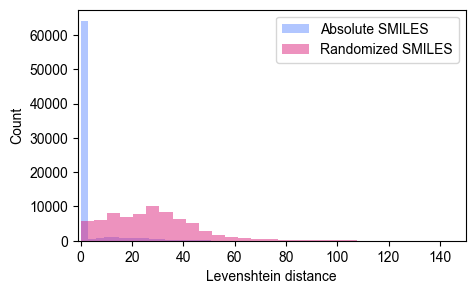

In [88]:
plt.figure(figsize=(5, 3))

plt.hist(dataset['levenshtein_absolute_smiles'], bins=50, color='#648FFF', alpha=0.5, label='Absolute SMILES')
plt.hist(dataset['levenshtein_randomized_smiles'], bins=50, color='#DC267F', alpha=0.5, label='Randomized SMILES')

plt.xlabel('Levenshtein distance')
plt.ylabel('Count')

plt.xlim(-1, 150)

plt.legend()
plt.savefig('plots/levenshtein_distance.png', dpi=1200)

## Prediction Analysis

#### Import data frame

We use a custom function to read the predictions and add the different accuracy metrics to the data frame.

In [6]:
df_not_augmented = get_accuracies('not_augmented')
df_augmented_2x = get_accuracies('augmented_2x')
df_augmented_5x = get_accuracies('augmented_5x')
df_augmented_10x = get_accuracies('augmented_10x')
df_augmented_20x = get_accuracies('augmented_20x')
df_augmented_50x = get_accuracies('augmented_50x')
df_mixed_augmented = get_accuracies('mixed_augmented')
df_partial_augmented_5x = get_accuracies('partial_augmented_5x')
df_not_augmented_scrambled = get_accuracies('not_augmented_scrambled')
df_partial_augmented_5x_scrambled = get_accuracies('partial_augmented_5x_scrambled')

In [4]:
df_mixed_augmented_partial = get_partial_accuracies('mixed_augmented_partial')
df_partial_augmented_5x_partial = get_partial_accuracies('partial_augmented_5x_partial')
df_partial_augmented_5x_scrambled_partial = get_partial_accuracies('partial_augmented_5x_partial_scrambled')

Add number of stereocenters to all data frames

In [7]:
def add_nstereo(df):
    df['#stereo'] = df['target'].apply(lambda x: len(get_stereocenters(Chem.MolFromSmiles(x[0]))))
    df['#stereo'] = df['#stereo'].apply(lambda x: x if x <= 10 else 11)
    return df

df_not_augmented = add_nstereo(df_not_augmented)
df_augmented_2x = add_nstereo(df_augmented_2x)
df_augmented_5x = add_nstereo(df_augmented_5x)
df_augmented_10x = add_nstereo(df_augmented_10x)
df_augmented_20x = add_nstereo(df_augmented_20x)
df_augmented_50x = add_nstereo(df_augmented_50x)
df_mixed_augmented = add_nstereo(df_mixed_augmented)
df_partial_augmented_5x = add_nstereo(df_partial_augmented_5x)
df_not_augmented_scrambled = add_nstereo(df_not_augmented_scrambled)
df_partial_augmented_5x_scrambled = add_nstereo(df_partial_augmented_5x_scrambled)

df_mixed_augmented_partial = add_nstereo(df_mixed_augmented_partial)
df_partial_augmented_5x_partial = add_nstereo(df_partial_augmented_5x_partial)
df_partial_augmented_5x_scrambled_partial = add_nstereo(df_partial_augmented_5x_scrambled_partial)

#### Determine accuracies per stereocenter

Determining the accuracy of the predictions per unassigned stereocenter (up to 10)

In [20]:
def add_unassigned(df):
    df['stereo_info'] = df['source'].apply(lambda x: get_stereocenters(Chem.MolFromSmiles(x)))
    df['#unassigned'] = df['stereo_info'].apply(lambda x: x.count('NoValue'))
    df['#unassigned'] = df['#unassigned'].apply(lambda x: x if x <= 10 else 11)
    return df

df_not_augmented = add_unassigned(df_not_augmented)
df_augmented_2x = add_unassigned(df_augmented_2x)
df_augmented_5x = add_unassigned(df_augmented_5x)
df_augmented_10x = add_unassigned(df_augmented_10x)
df_augmented_20x = add_unassigned(df_augmented_20x)
df_augmented_50x = add_unassigned(df_augmented_50x)
df_mixed_augmented = add_unassigned(df_mixed_augmented)
df_partial_augmented_5x = add_unassigned(df_partial_augmented_5x)
df_not_augmented_scrambled = add_unassigned(df_not_augmented_scrambled)
df_partial_augmented_5x_scrambled = add_unassigned(df_partial_augmented_5x_scrambled)

df_mixed_augmented_partial = add_unassigned(df_mixed_augmented_partial)
df_partial_augmented_5x_partial = add_unassigned(df_partial_augmented_5x_partial)
df_partial_augmented_5x_scrambled_partial = add_unassigned(df_partial_augmented_5x_scrambled_partial)

In [21]:
df_not_augmented_accs = unassigned_accuracies(df_not_augmented)
df_augmented_2x_accs = unassigned_accuracies(df_augmented_2x)
df_augmented_5x_accs = unassigned_accuracies(df_augmented_5x)
df_augmented_10x_accs = unassigned_accuracies(df_augmented_10x)
df_augmented_20x_accs = unassigned_accuracies(df_augmented_20x)
df_augmented_50x_accs = unassigned_accuracies(df_augmented_50x)
df_mixed_augmented_accs = unassigned_accuracies(df_mixed_augmented)
df_partial_augmented_5x_accs = unassigned_accuracies(df_partial_augmented_5x)
df_not_augmented_scrambled_accs = unassigned_accuracies(df_not_augmented_scrambled)
df_partial_augmented_5x_scrambled_accs = unassigned_accuracies(df_partial_augmented_5x_scrambled)

df_mixed_augmented_partial_accs = unassigned_accuracies(df_mixed_augmented_partial)
df_partial_augmented_5x_partial_accs = unassigned_accuracies(df_partial_augmented_5x_partial)
df_partial_augmented_5x_scrambled_partial_accs = unassigned_accuracies(df_partial_augmented_5x_scrambled_partial)

Combine augmentations in a list

In [22]:
augmentation_dataframes = {
    'Not Augmented': df_not_augmented_accs, 
    '2x Augmented': df_augmented_2x_accs, 
    '5x Augmented': df_augmented_5x_accs, 
    '10x Augmented': df_augmented_10x_accs, 
    '20x Augmented': df_augmented_20x_accs, 
    '50x Augmented': df_augmented_50x_accs,
    'Mixed Augmented': df_mixed_augmented_accs,
    'Mixed Augmented Partial': df_mixed_augmented_partial_accs,
    'Partial 5x Augmented': df_partial_augmented_5x_accs,
    'Partial 5x Augmented Partial': df_partial_augmented_5x_partial_accs,
    'Not Augmented Scrambled': df_not_augmented_scrambled_accs,
    'Partial 5x Augmented Scrambled': df_partial_augmented_5x_scrambled_accs,
    'Partial 5x Augmented Partial Scrambled': df_partial_augmented_5x_scrambled_partial_accs
    }

Accuracies

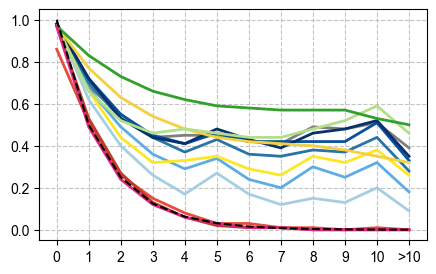

In [23]:
plt.figure(figsize=(5, 3))

colors = ['#7F7F7F', '#A6CEE3', '#5DADE2', '#2874A6', '#08519C', '#08306B', '#FDE725', '#F4D03F', '#B2DF8A', '#33A02C', '#E74C3C', '#C0392B', '#DC267F']

for (label, df), color in zip(augmentation_dataframes.items(), colors):
    plt.plot(df.index, df['top1'], label=label, color=color, linewidth=2)

x = np.arange(0, 12)
y = 1/2**x
plt.plot(x, y, color='black', linestyle='--', label='Random')

plt.xticks(ticks=np.arange(12), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '>10'])
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/stereocenter_accuracies.png', dpi=1200, bbox_inches='tight')

Per-stereocenter accuracies

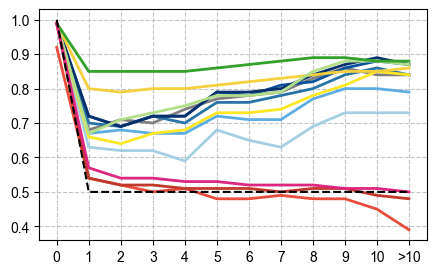

In [24]:
plt.figure(figsize=(5, 3))

colors = ['#7F7F7F', '#A6CEE3', '#5DADE2', '#2874A6', '#08519C', '#08306B', '#FDE725', '#F4D03F', '#B2DF8A', '#33A02C', '#E74C3C', '#C0392B', '#DC267F']

for (label, df), color in zip(augmentation_dataframes.items(), colors):
    plt.plot(df.index, df['top1_wt'], label=label, color=color, linewidth=2)

x = np.arange(0, 12)
y = [1 if _ == 0 else 0.5 for _ in x]
plt.plot(x, y, color='black', linestyle='--', label='Random')

plt.xticks(ticks=np.arange(12), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '>10'])
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/stereocenter_accuracies_wt.png', dpi=1200, bbox_inches='tight')

#### Determine accuracies per compound class

In [32]:
coconut_complete['absolute_smiles'] = coconut_complete['absolute_smiles'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

df_not_augmented['source'] = df_not_augmented['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_augmented_2x['source'] = df_augmented_2x['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_augmented_5x['source'] = df_augmented_5x['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_augmented_10x['source'] = df_augmented_10x['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_augmented_20x['source'] = df_augmented_20x['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_augmented_50x['source'] = df_augmented_50x['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_mixed_augmented['source'] = df_mixed_augmented['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_partial_augmented_5x['source'] = df_partial_augmented_5x['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_not_augmented_scrambled['source'] = df_not_augmented_scrambled['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_partial_augmented_5x_scrambled['source'] = df_partial_augmented_5x_scrambled['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
                                                                                                
df_mixed_augmented_partial['source'] = df_mixed_augmented_partial['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_partial_augmented_5x_partial['flat'] = df_partial_augmented_5x_partial['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))
df_partial_augmented_5x_scrambled_partial['flat'] = df_partial_augmented_5x_scrambled_partial['source'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), isomericSmiles=False))

In [33]:
df_not_augmented_merged = df_not_augmented.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_augmented_2x_merged = df_augmented_2x.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_augmented_5x_merged = df_augmented_5x.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_augmented_10x_merged = df_augmented_10x.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_augmented_20x_merged = df_augmented_20x.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_augmented_50x_merged = df_augmented_50x.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_mixed_augmented_merged = df_mixed_augmented.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_partial_augmented_5x_merged = df_partial_augmented_5x.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_not_augmented_scrambled_merged = df_not_augmented_scrambled.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_partial_augmented_5x_scrambled_merged = df_partial_augmented_5x_scrambled.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()

df_mixed_augmented_partial_merged = df_mixed_augmented_partial.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='source', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_partial_augmented_5x_partial_merged = df_partial_augmented_5x_partial.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='flat', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()
df_partial_augmented_5x_scrambled_partial_merged = df_partial_augmented_5x_scrambled_partial.merge(coconut_complete[['absolute_smiles', 'chemical_class_new']], left_on='flat', right_on='absolute_smiles', how='left').drop(columns=['absolute_smiles']).dropna()

In [51]:
def chemical_class_accuracies(df):
    accuracies = {  
        'top1': [],
        'top2': [],
        'top3': [],
        'top1_wt': [],
        'top2_wt': [],
        'top3_wt': []
    }
    
    categories = np.sort(df['chemical_class_new'].astype(str).unique())
    
    for category in categories: 
        df_cat = df[(df['chemical_class_new'].astype(str) == category) & (df['#stereo'] != 0)]
        print(category, len(df_cat))
        accuracies['top1'].append(df_cat['top1'].mean())
        accuracies['top2'].append(df_cat['top2'].mean())
        accuracies['top3'].append(df_cat['top3'].mean())
        accuracies['top1_wt'].append(df_cat['top1_wt'].mean())
        accuracies['top2_wt'].append(df_cat['top2_wt'].mean())
        accuracies['top3_wt'].append(df_cat['top3_wt'].mean())
    
    accuracies = pd.DataFrame(accuracies)
    accuracies.index = categories
    accuracies = accuracies.sort_index()
    accuracies = accuracies.round(3)
    return accuracies

In [46]:
df_not_augmented_merged_accs = chemical_class_accuracies(df_not_augmented_merged)
df_augmented_2x_merged_accs = chemical_class_accuracies(df_augmented_2x_merged)
df_augmented_5x_merged_accs = chemical_class_accuracies(df_augmented_5x_merged)
df_augmented_10x_merged_accs = chemical_class_accuracies(df_augmented_10x_merged)
df_augmented_20x_merged_accs = chemical_class_accuracies(df_augmented_20x_merged)
df_augmented_50x_merged_accs = chemical_class_accuracies(df_augmented_50x_merged)
df_mixed_augmented_merged_accs = chemical_class_accuracies(df_mixed_augmented_merged)
df_partial_augmented_5x_merged_accs = chemical_class_accuracies(df_partial_augmented_5x_merged)
df_not_augmented_scrambled_merged_accs = chemical_class_accuracies(df_not_augmented_scrambled_merged)
df_partial_augmented_5x_scrambled_merged_accs = chemical_class_accuracies(df_partial_augmented_5x_scrambled_merged)

df_mixed_augmented_partial_merged_accs = chemical_class_accuracies(df_mixed_augmented_partial_merged)
df_partial_augmented_5x_partial_merged_accs = chemical_class_accuracies(df_partial_augmented_5x_partial_merged)
df_partial_augmented_5x_scrambled_partial_merged_accs = chemical_class_accuracies(df_partial_augmented_5x_scrambled_partial_merged)

In [47]:
chemical_class_dataframes = {
    'Not Augmented': df_not_augmented_merged_accs,
    '2x Augmented': df_augmented_2x_merged_accs,
    '5x Augmented': df_augmented_5x_merged_accs,
    '10x Augmented': df_augmented_10x_merged_accs,
    '20x Augmented': df_augmented_20x_merged_accs,
    '50x Augmented': df_augmented_50x_merged_accs,
    'Mixed Augmented': df_mixed_augmented_merged_accs,
    'Mixed Augmented Partial': df_mixed_augmented_partial_merged_accs,
    'Partial 5x Augmented': df_partial_augmented_5x_merged_accs,
    'Partial 5x Augmented Partial': df_partial_augmented_5x_partial_merged_accs,
    'Not Augmented Scrambled': df_not_augmented_scrambled_merged_accs,
    'Partial 5x Augmented Scrambled': df_partial_augmented_5x_scrambled_merged_accs,
    'Partial 5x Augmented Partial Scrambled': df_partial_augmented_5x_scrambled_partial_merged_accs
    }

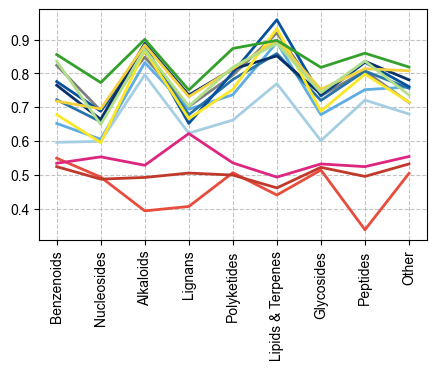

In [48]:
plt.figure(figsize=(5, 3))

colors = ['#7F7F7F', '#A6CEE3', '#5DADE2', '#2874A6', '#08519C', '#08306B', '#FDE725', '#F4D03F', '#B2DF8A', '#33A02C', '#E74C3C', '#C0392B', '#DC267F']

for (label, df), color in zip(chemical_class_dataframes.items(), colors):
    plt.plot(df.index, df['top1_wt'], label=label, color=color, linewidth=2)

plt.xticks(ticks=np.arange(9), labels=['Benzenoids', 'Nucleosides', 'Alkaloids', 'Lignans', 'Polyketides', 'Lipids & Terpenes', 'Glycosides', 'Peptides', 'Other'], rotation=90)
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/chemical_class_accuracies.png', dpi=1200, bbox_inches='tight')

In [50]:
data = {}
for label, df in chemical_class_dataframes.items():
    data[label] = df['top1_wt'].to_dict()

plot_data_df = pd.DataFrame(data).transpose()
plot_data_df.columns.name = 'Chemical_Class'
plot_data_df = plot_data_df*100
plot_data_df

Chemical_Class,Alkaloids,Benzenoids,Glycosides,Lignans,Lipids & Terpenes,Nucleosides,Other,Peptides,Polyketides
Not Augmented,82.4,69.0,84.8,70.2,79.5,92.0,73.4,80.7,71.4
2x Augmented,59.6,59.9,79.6,62.3,66.2,77.0,60.1,72.1,68.0
5x Augmented,65.2,60.5,83.2,69.4,73.7,89.2,67.8,75.2,76.0
10x Augmented,72.2,65.7,86.6,67.8,78.2,85.9,72.0,80.7,75.6
20x Augmented,77.6,68.8,88.4,65.2,80.3,95.9,73.4,83.3,76.1
50x Augmented,76.5,66.4,88.9,73.6,81.3,85.2,73.9,83.6,78.1
Mixed Augmented,67.8,59.5,86.8,66.6,75.3,93.3,68.8,79.8,71.5
Mixed Augmented Partial,71.8,69.5,88.4,73.1,81.4,89.8,75.3,81.4,80.8
Partial 5x Augmented,83.6,64.9,87.1,70.3,81.9,88.9,74.3,83.7,73.6
Partial 5x Augmented Partial,85.6,77.3,90.1,75.1,87.4,89.8,81.8,86.0,81.9
